In [ ]:
!apt install python3.10-venv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10-venv is already the newest version (3.10.12-1~22.04.6).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# creating virtual environment
!python -m venv "input environment path name here"

In [ ]:
# activating virtual environment
!source "input environment activation file path here"

In [ ]:
# upgrading pip to latest version
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# installation of system dependencies (portaudio and others)
!apt-get install -y portaudio19-dev
!apt-get install -y python3-pyaudio

# installing dependencies
!pip install gradio
!pip install SpeechRecognition
!pip install pyaudio
!pip install transformers
!pip install torch
!pip install gTTS

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (235 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.

In [ ]:
# importing dependencies
import gradio as gr
import torch
from transformers import pipeline
import speech_recognition as sr
from gtts import gTTS
import os
import re
import sqlite3

# Initialize Hugging Face pipeline for text classification (BERT-based)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if torch.cuda.is_available() else -1)

# Define the required parameters
required_fields = ['project', 'amount', 'reason']

# Initialize recognizer class
recognizer = sr.Recognizer()

# Set up SQLite database (will create if it doesn't exist)
def init_db():
    conn = sqlite3.connect('input database file path here')
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS requests (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        project TEXT,
                        amount TEXT,
                        reason TEXT)''')
    conn.commit()
    conn.close()

# Function to store a request in the database
def store_request(user_data):
    conn = sqlite3.connect('input database file path here')
    cursor = conn.cursor()
    cursor.execute("INSERT INTO requests (project, amount, reason) VALUES (?, ?, ?)",
                   (user_data['project'], user_data['amount'], user_data['reason']))
    conn.commit()
    conn.close()
    return "Request successfully stored in the database!"

# Function to recognize speech
def recognize_audio(audio_file):
    try:
        # Ensure the audio file is being passed correctly
        with sr.AudioFile(audio_file.name) as source:
            audio = recognizer.record(source)

        recognized_text = recognizer.recognize_google(audio)
        print(f"Recognized: {recognized_text}")  # Debug output
        return recognized_text
    except sr.UnknownValueError:
        print("Error: Could not understand the audio.")
        return "Sorry, I did not understand that."
    except sr.RequestError as e:
        print(f"Error: Could not request results; {e}")
        return "Sorry, I am unable to connect to the service."

# Handle missing fields
def ask_missing_fields(user_data):
    missing = [field for field in required_fields if field not in user_data]
    if missing:
        return f"Please tell me the {missing[0]}."
    else:
        return "Are you sure you want to proceed with the following request? " + \
               f"Project: {user_data['project']}, Amount: {user_data['amount']}, Reason: {user_data['reason']}"

# Function to speak the response using gTTS (Google Text-to-Speech)
def speak_response(text):
    try:
        tts = gTTS(text=text, lang='en', slow=False)  # Text-to-speech in English
        audio_file_path = "input audio file path here"
        tts.save(audio_file_path)  # Save speech to an audio file
        return gr.Audio(audio_file_path, autoplay=True)  # Return Gradio audio component
    except Exception as e:
        print(f"Error in text-to-speech: {e}")
        return None

# Regex-based helper functions
def extract_project(text):
    project_patterns = [
        r"\b(project|mission|objective|task)[\s:]*([A-Za-z0-9\-\.]+)\b",  # keyword followed by alphanumeric code or name
        r"\b([A-Za-z0-9\-\.]+)[\s]*(project|mission|objective|task)\b"   # alphanumeric code or name followed by keyword
    ]
    for pattern in project_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            project = match.group(2).strip()
            if re.search(r"\d", project):  # If it's a purely numeric value, don't consider it a project
                return None
            return project
    return None

def extract_amount(text):
    amount_patterns = [
        r"\b([\d\.,]+)\s*(taka|rupee|dollar|yen|real|riyal|lira|krone|krona|rupiah|pound|sterling|bdt|usd|eur|inr|gbp|aud|jpy|cny|[A-Za-z]{2,4})\b",
        r"\b([A-Za-z]{3,5})\s*([\d\.,]+)\b",
        r"\b([\d\.,]+)\b"
    ]
    for pattern in amount_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return None

def extract_reason(text):
    reason_patterns = [
        r"\b(reason|purpose|cause|for|because)[\s:]*([\w\s]+)",
        r"\b([\w\s]+)[\s]*(reason|purpose|cause|for|because)\b"
    ]
    for pattern in reason_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(2).strip()
    return None

# Main function for processing the conversation (handles both audio and text input)
def voice_assistant(audio_file=None, user_text=None, user_data={}):
    # Check if user provided text or audio input
    if user_text:
        user_input = user_text
    elif audio_file:
        if not audio_file:
            return "Error: The audio file was not uploaded correctly. Please try again."
        user_input = recognize_audio(audio_file)  # Convert audio to text
    else:
        return "Error: Please provide either audio or text input."

    # Process the user's input and generate text-to-speech response
    response_text = f"You said: {user_input}"
    audio_response = speak_response(response_text)

    # Use regex first to try to extract the fields
    if 'project' not in user_data:
        project = extract_project(user_input)
        if project:
            user_data['project'] = project
            audio_response = speak_response(f"Project '{project}' recorded.")

    if 'amount' not in user_data:
        amount = extract_amount(user_input)
        if amount:
            user_data['amount'] = amount
            audio_response = speak_response(f"Amount '{amount}' recorded.")

    if 'reason' not in user_data:
        reason = extract_reason(user_input)
        if reason:
            user_data['reason'] = reason
            audio_response = speak_response(f"Reason '{reason}' recorded.")

    # If any field is still missing, ask the user for more information
    if 'project' not in user_data or 'amount' not in user_data or 'reason' not in user_data:
        missing_response = ask_missing_fields(user_data)
        audio_response = speak_response(missing_response)

    # If all fields are filled, ask for confirmation
    if all(field in user_data for field in required_fields):
        confirmation = ask_missing_fields(user_data)
        audio_response = speak_response(confirmation)
        store_request(user_data)  # Store the completed request in the database

        # Reset the user data after successful request
        user_data.clear()  # Clear the user_data to start fresh for next request

    assistant_response = "Please confirm your request."

    # Return both text and audio responses
    return assistant_response, audio_response

# Gradio interface setup
iface = gr.Interface(
    fn=voice_assistant,
    inputs=[
        gr.Audio(label="Speak your request"),
        gr.Textbox(lines=2, placeholder="Type your message", label="Or type to the Assistant")
    ],
    outputs=[
        gr.Textbox(label="Assistant's Response (Text)"),
        gr.Audio(label="Assistant's Response (Audio)"),
    ],
    live=False  # Set to False to make the user explicitly click the submit button
)

# Initialize the database
init_db()

# Launch the interface
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://877d9c7458057876a7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


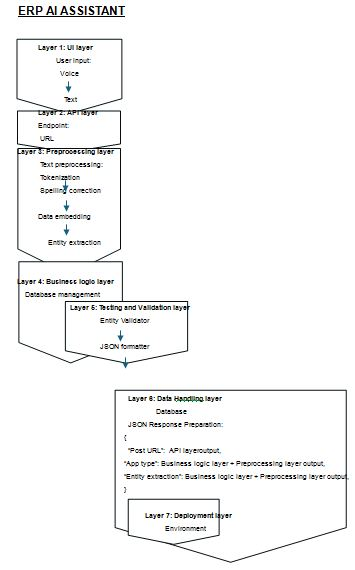